In [233]:
import pandas as pd
import os

# df = pd.read_csv('C:/Cand.merc.BI/2. Semester/Data Science Project/Project/BilbasenProject/data/data_analysis/engineered_data_ID_4_pre_split.csv')
df = pd.read_csv('C:/Simon/Projekter/Data Science Project/BilbasenProject/data/data_analysis/engineered_data_ID_4_pre_split.csv')

In [234]:
df.dtypes

Dealer/private             bool
Price_kr                  int64
Mileage_km                int64
Color                    object
AWD/RWD                    bool
Age_in_months             int64
Acceleration_category    object
Range_category           object
dtype: object

Convert object to category

In [235]:
df['Acceleration_category'] = pd.Categorical(df['Acceleration_category'], categories=['fast', 'medium', 'slow'], ordered=True)
df['Range_category'] = pd.Categorical(df['Range_category'], categories=['short', 'medium', 'long'], ordered=True)
df['Color'] = pd.Categorical(df['Color'])

In [236]:
df['Acceleration_category'].dtypes.ordered

True

In [237]:
df['Range_category'].dtypes.ordered

True

In [238]:
df['Color'].dtypes.ordered

False

In [239]:
df

,Dealer/private,Price_kr,Mileage_km,Color,AWD/RWD,Age_in_months,Acceleration_category,Range_category
0,True,299800,2000,Grey,False,33,medium,medium
1,True,329800,5000,Blue,False,19,medium,medium
2,True,289900,7000,White,False,10,slow,long
3,True,419800,50,White,True,14,fast,short
4,True,359900,37,Silver,True,11,fast,medium
...,...,...,...,...,...,...,...,...
481,False,339000,15000,Black,False,18,medium,medium
482,False,350000,8000,White,True,15,fast,medium
483,False,295000,25000,Silver,False,17,medium,medium
484,False,299500,42000,Grey,False,37,medium,medium


In [240]:
df = df.drop(columns=['Color'])

In [241]:
import numpy as np
df['Mileage_km'] = np.sqrt(df['Mileage_km'])
df['Age_in_months'] = np.sqrt(df['Age_in_months'])

In [242]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=500)

Just checking the distributions of train and test

array([[<Axes: title={'center': 'Price_kr'}>,
        <Axes: title={'center': 'Mileage_km'}>],
       [<Axes: title={'center': 'Age_in_months'}>, <Axes: >]],
      dtype=object)

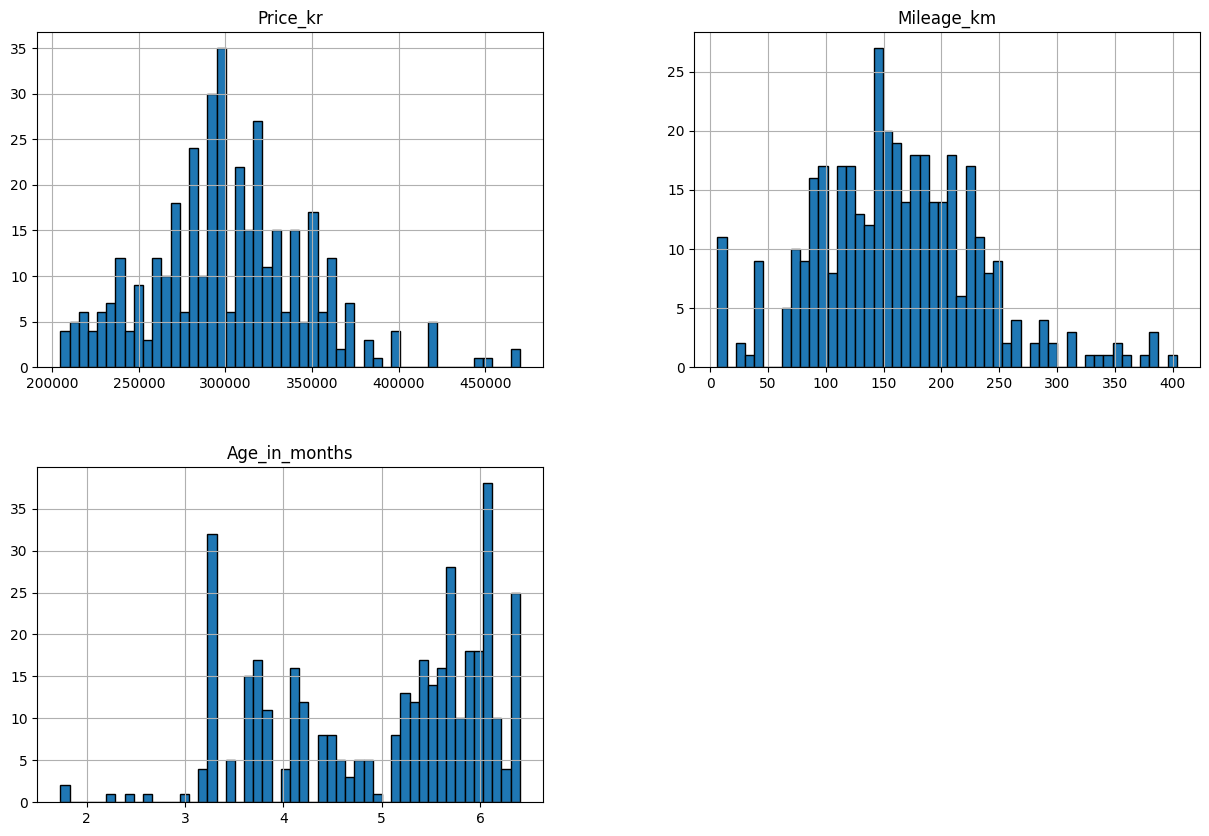

In [243]:
train_df.hist(bins=50, edgecolor='black', figsize=(15, 10))

array([[<Axes: title={'center': 'Price_kr'}>,
        <Axes: title={'center': 'Mileage_km'}>],
       [<Axes: title={'center': 'Age_in_months'}>, <Axes: >]],
      dtype=object)

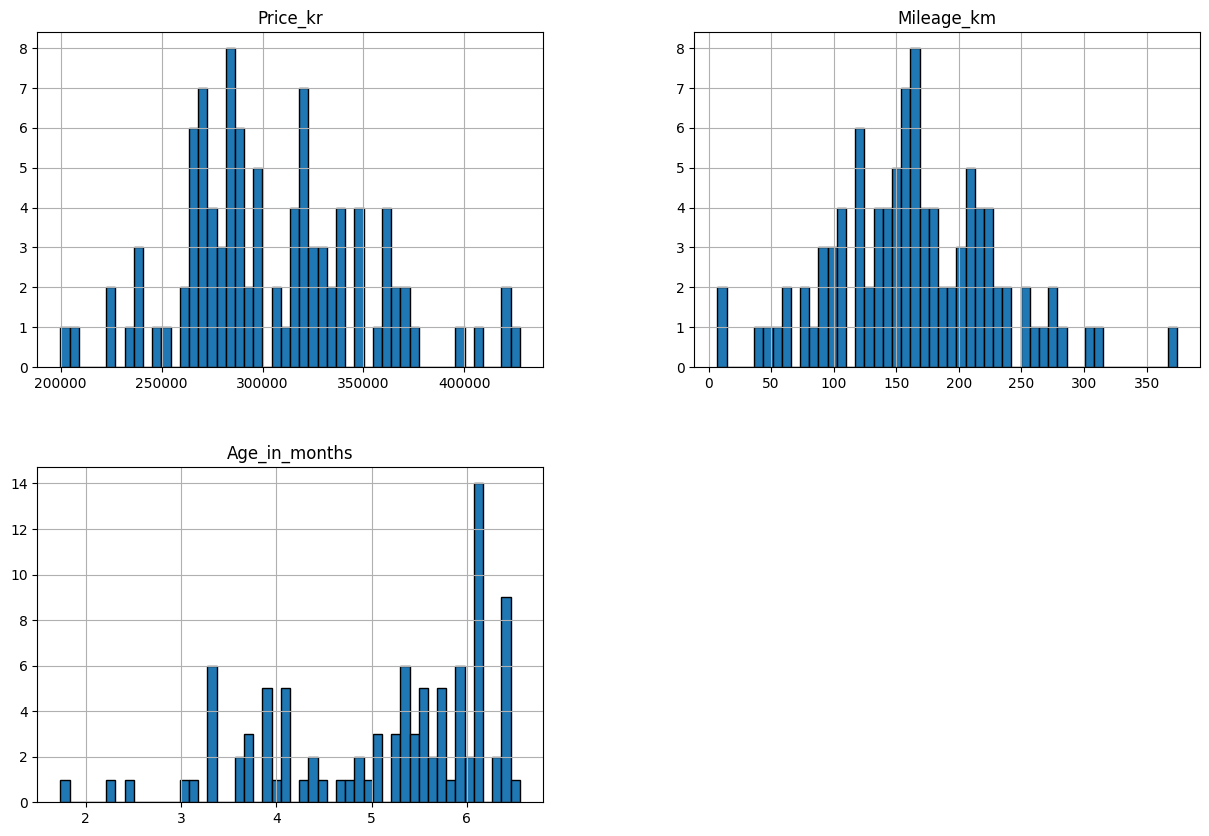

In [244]:
test_df.hist(bins=50, edgecolor='black', figsize=(15, 10))

Preparing for the models on training and testing

In [245]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Extract Features and Target from train_df
X_train = train_df.drop(columns=['Price_kr'])
y_train = train_df['Price_kr']

# Convert categorical features to dummy variables
X_train = pd.get_dummies(X_train, drop_first=True)

# Ensure the test set has the same dummy variables as the training set
X_test = test_df.drop(columns=['Price_kr'])
X_test = pd.get_dummies(X_test, drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_test = test_df['Price_kr']

Creating the models

In [246]:
#Paramgrid for tuning RF and Gradiant boosting

#For Random forest
param_grid_RF = {
    'n_estimators': [50, 100, 150],
    'max_depth': [20, 30, 50],  # Reasonable depth options
    'min_samples_split': [10, 15, 20],  # Balanced range for min_samples_split
    'min_samples_leaf': [4, 6, 8],  # Balanced range for min_samples_leaf
    'max_features': ['sqrt', 'log2'],  # Focused options
    'bootstrap': [True]  # Commonly used bootstrap setting
}


#For Gradiant boosting
param_grid_GB = {
    'n_estimators': [150, 200, 250],  # Focused range of trees
    'learning_rate': [0.01, 0.05, 0.1],  # Balanced learning rates
    'max_depth': [5, 7, 10],  # Reasonable depth options
    'min_samples_split': [10, 15, 20],  # Balanced range for min_samples_split
    'min_samples_leaf': [4, 6, 8],  # Balanced range for min_samples_leaf
    'max_features': ['sqrt', 'log2'],  # Focused options
    'subsample': [0.8, 0.9]  # Commonly used subsampling settings
}



In [247]:
#Grid searching

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

#For Random forest
grid_search_RF = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_RF,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Perform Grid Search
grid_search_RF.fit(X_train, y_train)

# Get the best parameters
best_params_RF = grid_search_RF.best_params_
print("Best parameters found for RF: ", best_params_RF)


# For gradiant boosting
grid_search_GB = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid_GB,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Perform Grid Search
grid_search_GB.fit(X_train, y_train)

# Get the best parameters
best_params_GB = grid_search_GB.best_params_
print("Best parameters found for GB: ", best_params_GB)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters found for RF:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters found for GB:  {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 150, 'subsample': 0.8}


In [248]:
#Train the linear regression Model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

#Linear model
model_train_LM = LinearRegression()
model_train_LM.fit(X_train, y_train)

#KNN model
model_train_KNN = KNeighborsRegressor(n_neighbors=4)
model_train_KNN.fit(X_train, y_train)

#Random Forest model
model_train_RF = RandomForestRegressor(**best_params_RF, random_state=42)
model_train_RF.fit(X_train, y_train)

#Gradient Boosting Regressor model
model_train_GBR = GradientBoostingRegressor(**best_params_GB, random_state=42)
model_train_GBR.fit(X_train, y_train)

# Instantiate and train the SVR model
model_train_SVR = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # Adjust parameters as needed
model_train_SVR.fit(X_train, y_train)


SVR()

In [249]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Function to evaluate a model and return the metrics
def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    mse_train = mean_squared_error(y_train, train_predictions)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, train_predictions)
    
    mse_test = mean_squared_error(y_test, test_predictions)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, test_predictions)
    
    return mse_train, rmse_train, r2_train, mse_test, rmse_test, r2_test

# List of models to evaluate
models = {
    'Linear Regression': model_train_LM,
    'KNN': model_train_KNN,
    'Random Forest': model_train_RF,
    'Gradient Boosting': model_train_GBR,
    'SVR': model_train_SVR
}

# Create a list to store the results
results = []

# Evaluate each model and store the results in the list
for model_name, model in models.items():
    mse_train, rmse_train, r2_train, mse_test, rmse_test, r2_test = evaluate_model(model, X_train, y_train, X_test, y_test)
    results.append({
        'Model': model_name, 
        'MSE_Train': mse_train, 
        'RMSE_Train': rmse_train, 
        'R2_Train': r2_train,
        'MSE_Test': mse_test, 
        'RMSE_Test': rmse_test, 
        'R2_Test': r2_test
    })

# Convert the list of results into a DataFrame
results_df = pd.DataFrame(results)

results_df


,Model,MSE_Train,RMSE_Train,R2_Train,MSE_Test,RMSE_Test,R2_Test
0,Linear Regression,5.183483e+08,22767.264516,0.750609,5.788464e+08,24059.227586,0.724676
1,KNN,8.298526e+08,28807.161670,0.600737,1.387288e+09,37246.310450,0.340146
2,Random Forest,4.115305e+08,20286.214315,0.802002,6.038733e+08,24573.833470,0.712772
3,Gradient Boosting,3.210889e+08,17918.952827,0.845516,5.911109e+08,24312.773277,0.718842
4,SVR,2.081585e+09,45624.395742,-0.001504,2.125815e+09,46106.564503,-0.011130


Testing the models results